In [1]:
from utils import DEVICE, SYMBOLS, ID2SYM, SYM2ID
import time
from tqdm import tqdm
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from dataset import HINT, HINT_collate
from jointer import Jointer
from train import parse_args, draw_parse

import torch
import numpy as np
import random
torch.multiprocessing.set_sharing_strategy('file_system')

import argparse
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from PIL import Image
symbol_images_dir = 'data/symbol_images/'
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def draw_ast(ast):
    sentence = ''.join(map(ID2SYM, ast.pt.sentence))
    res = ast.res_all()
    head = ast.pt.head
    tree = draw_parse(list(zip(sentence, res)), head)
    return tree

In [3]:
train_set = HINT('train')
val_set = HINT('val')
# test_set = HINT('val')
test_set = HINT('test')
print('train:', len(train_set), 'val:', len(val_set), 'test:', len(test_set))

train: 11170 val: 4900 test: 48910


In [15]:
sys.argv = sys.argv[:1]
args = parse_args()
args.syntax = True
args.semantics = True
model = Jointer(args)
model.to(DEVICE)
if args.perception_pretrain and not args.perception:
    model.perception.load({'model': torch.load(args.perception_pretrain)})

st_epoch = 0
if args.resume:
    st_epoch = model.load(args.resume)
    if st_epoch is None:
        st_epoch = 0

print(args)
model.print()

Namespace(curriculum=False, epochs=100, epochs_eval=5, excludes='!', output_dir='outputs/', perception=False, perception_pretrain='data/perception-pretrain/model.pth.tar_78.2_match', resume=None, seed=0, semantics=True, syntax=True)
ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), st

perception


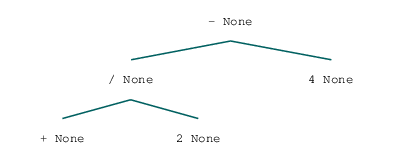

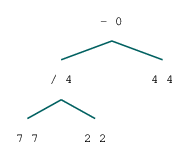

7/3-4 = 0


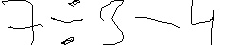

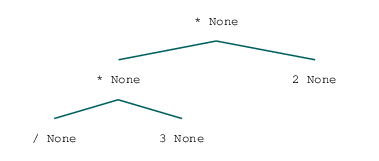

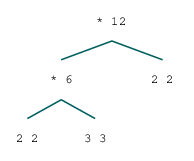

2*3*2 = 12


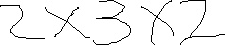

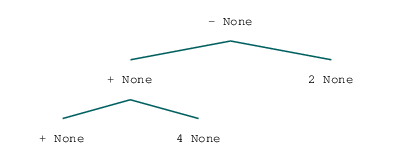

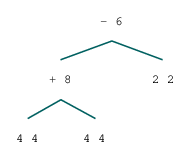

4+4-2 = 6


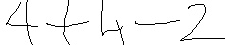

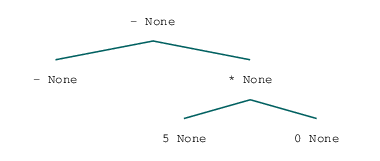

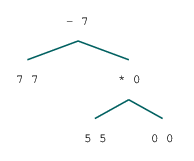

7-5*0 = 7


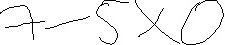

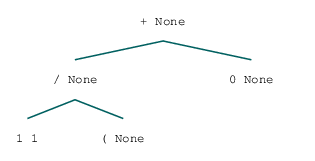

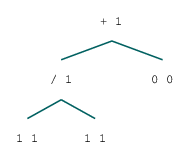

1/1+0 = 1


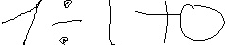

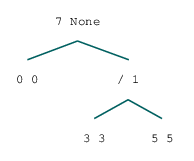

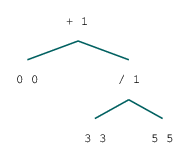

0+3/5 = 1


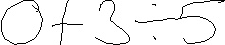

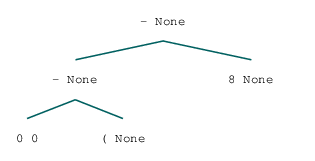

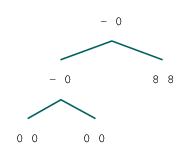

0-1-8 = 0


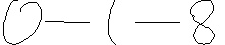

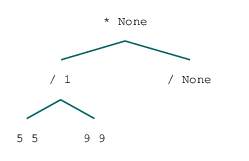

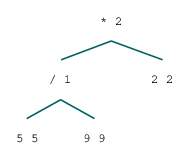

5/9*2 = 2


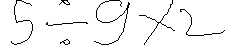

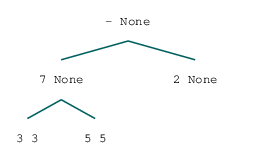

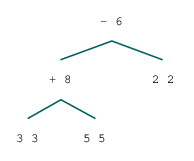

3+5-2 = 6


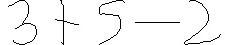

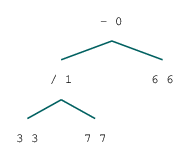

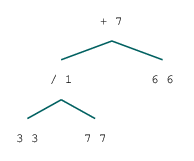

3/7+6 = 7


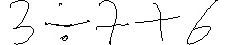

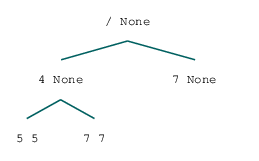

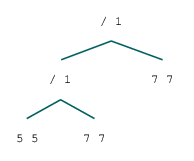

5/7/4 = 1


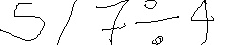

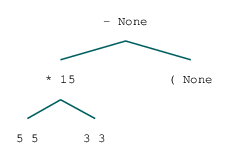

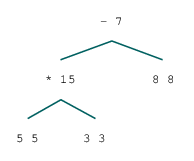

5*3-8 = 7


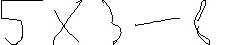

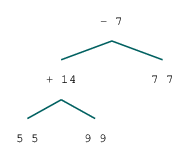

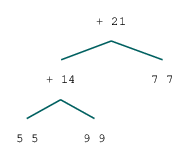

5+9+7 = 21


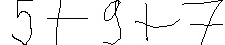

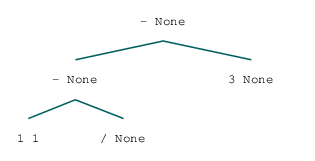

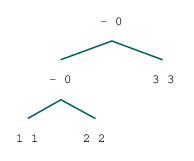

1-2-3 = 0


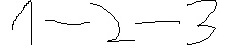

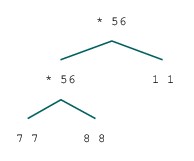

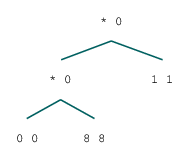

4*0*1 = 0


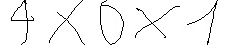

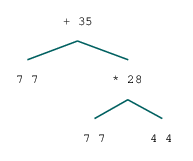

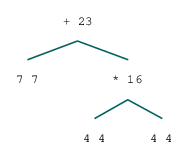

7+4*4 = 23


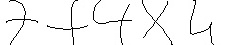

KeyboardInterrupt: Interrupted by user

In [14]:
dataset = val_set
dataset.filter_by_len(min_len=5, max_len=5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=HINT_collate)
model.eval() 
model.epoch = 1
print(model.learned_module)
model.clear_buffer()
with torch.no_grad():
    for sample in dataloader:
        res = sample['res']
        expr = sample['expr']
        dep = sample['head']

        model.clear_buffer()
        model.deduce(sample)
        model.abduce(res, sample['img_paths'])
        if model.buffer:
            ast = model.ASTs[0]
            ast_abduce = model.buffer[0]
            if ast.res() == ast_abduce.res():
                continue
            display(draw_ast(ast))
            display(draw_ast(ast_abduce))
            print(expr[0], '=', res[0].item())
            display(render_img(sample['img_paths'][0]))
            input()
        
        